In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
from PIL import Image
from typing import Any, Callable, Dict, List, Optional, Tuple

class MyDataLoader(torchvision.datasets.MNIST):


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        resize_transform = transforms.Compose([
            transforms.Resize((20, 20))
        ])
        img, _ = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with default datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")
        small_img = resize_transform(img)

        if self.transform is not None:
            img = self.transform(img)
            small_img = self.transform(small_img)

        return img, small_img

data_dir = 'mydataset'

train_dataset = MyDataLoader(data_dir, train=True, download=True)
test_dataset  = MyDataLoader(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [2]:
class SmallEncoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(2 * 2 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class BigEncoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class SmallDecoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 2 * 2 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 2, 2))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class BigDecoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
loss_fn = torch.nn.MSELoss()
lr= 0.001
torch.manual_seed(0)
d = 32

encoder = SmallEncoder(encoded_space_dim=d)
decoder = BigDecoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoder = encoder.to(device)
decoder = decoder.to(device)

Selected device: cuda


In [4]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, small_image_batch in dataloader:
        # Move tensor to the proper device
        small_image_batch = small_image_batch.to(device)
        # Encode data
        encoded_data = encoder(small_image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch.to(device))
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % loss.data)
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [5]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, small_image_batch in dataloader:
            # Move tensor to the proper device
            small_image_batch = small_image_batch.to(device)
            # Encode data
            encoded_data = encoder(small_image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:
def plot_test(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      size_index = 0 #  for 28x28
      size_index = 1 #  for 20x20
      img = test_dataset[t_idx[i]][size_index].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(test_dataset[t_idx[i]][0].unsqueeze(1).to(device).cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Upsampled images')
    plt.show()

	 partial train loss (single batch): 0.245213
	 partial train loss (single batch): 0.239675
	 partial train loss (single batch): 0.235739
	 partial train loss (single batch): 0.231972
	 partial train loss (single batch): 0.228696
	 partial train loss (single batch): 0.226184
	 partial train loss (single batch): 0.224010
	 partial train loss (single batch): 0.221199
	 partial train loss (single batch): 0.219406
	 partial train loss (single batch): 0.217412
	 partial train loss (single batch): 0.215130
	 partial train loss (single batch): 0.213846
	 partial train loss (single batch): 0.211956
	 partial train loss (single batch): 0.210175
	 partial train loss (single batch): 0.208483
	 partial train loss (single batch): 0.206556
	 partial train loss (single batch): 0.205065
	 partial train loss (single batch): 0.203355
	 partial train loss (single batch): 0.201794
	 partial train loss (single batch): 0.200350
	 partial train loss (single batch): 0.198231
	 partial train loss (single batch

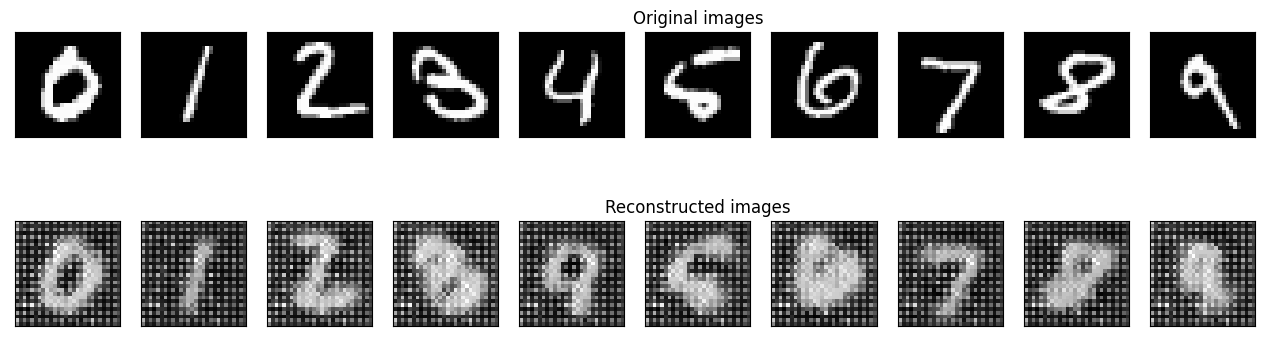

	 partial train loss (single batch): 0.078005
	 partial train loss (single batch): 0.076938
	 partial train loss (single batch): 0.076640
	 partial train loss (single batch): 0.076955
	 partial train loss (single batch): 0.075843
	 partial train loss (single batch): 0.075561
	 partial train loss (single batch): 0.075236
	 partial train loss (single batch): 0.076448
	 partial train loss (single batch): 0.074856
	 partial train loss (single batch): 0.074478
	 partial train loss (single batch): 0.074045
	 partial train loss (single batch): 0.074777
	 partial train loss (single batch): 0.073974
	 partial train loss (single batch): 0.072443
	 partial train loss (single batch): 0.073459
	 partial train loss (single batch): 0.072892
	 partial train loss (single batch): 0.072482
	 partial train loss (single batch): 0.071528
	 partial train loss (single batch): 0.072963
	 partial train loss (single batch): 0.071871
	 partial train loss (single batch): 0.070314
	 partial train loss (single batch

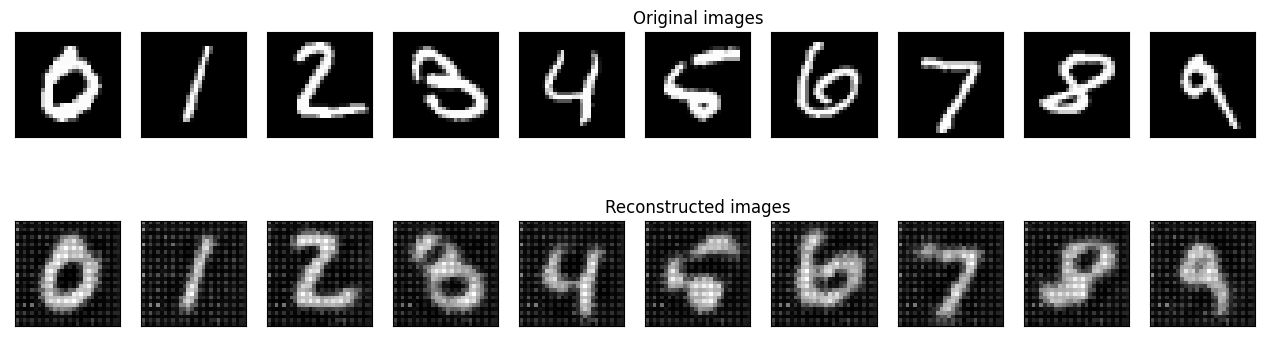

	 partial train loss (single batch): 0.035341
	 partial train loss (single batch): 0.034516
	 partial train loss (single batch): 0.034457
	 partial train loss (single batch): 0.034901
	 partial train loss (single batch): 0.034213
	 partial train loss (single batch): 0.033942
	 partial train loss (single batch): 0.033531
	 partial train loss (single batch): 0.034550
	 partial train loss (single batch): 0.033886
	 partial train loss (single batch): 0.033970
	 partial train loss (single batch): 0.032882
	 partial train loss (single batch): 0.033348
	 partial train loss (single batch): 0.033139
	 partial train loss (single batch): 0.032664
	 partial train loss (single batch): 0.033126
	 partial train loss (single batch): 0.032959
	 partial train loss (single batch): 0.033158
	 partial train loss (single batch): 0.032657
	 partial train loss (single batch): 0.033469
	 partial train loss (single batch): 0.032483
	 partial train loss (single batch): 0.032368
	 partial train loss (single batch

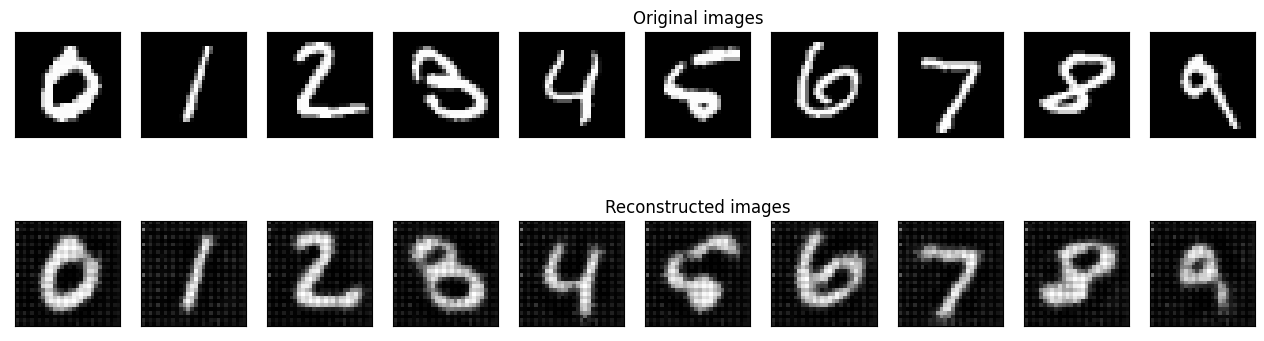

	 partial train loss (single batch): 0.020935
	 partial train loss (single batch): 0.020612
	 partial train loss (single batch): 0.020412
	 partial train loss (single batch): 0.021244
	 partial train loss (single batch): 0.020640
	 partial train loss (single batch): 0.020421
	 partial train loss (single batch): 0.019997
	 partial train loss (single batch): 0.021082
	 partial train loss (single batch): 0.020936
	 partial train loss (single batch): 0.021143
	 partial train loss (single batch): 0.020170
	 partial train loss (single batch): 0.020050
	 partial train loss (single batch): 0.020119
	 partial train loss (single batch): 0.020243
	 partial train loss (single batch): 0.019876
	 partial train loss (single batch): 0.020220
	 partial train loss (single batch): 0.020665
	 partial train loss (single batch): 0.020108
	 partial train loss (single batch): 0.020926
	 partial train loss (single batch): 0.020105
	 partial train loss (single batch): 0.019984
	 partial train loss (single batch

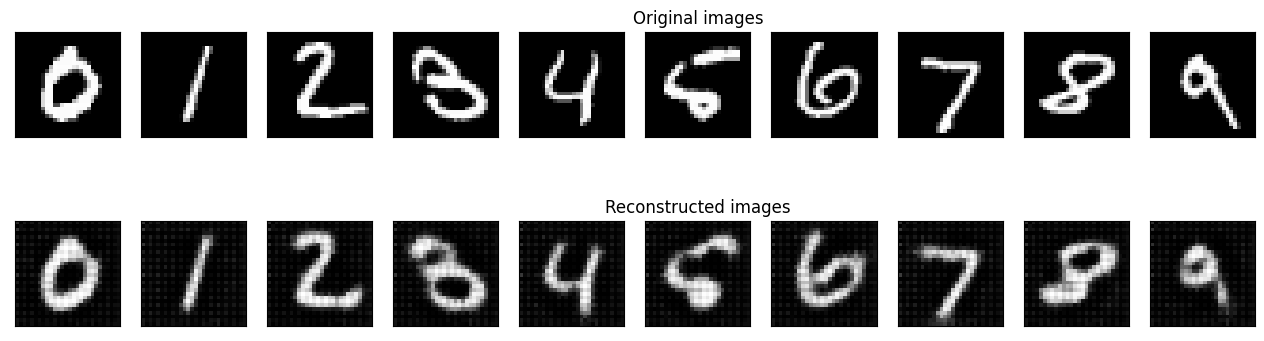

	 partial train loss (single batch): 0.015750
	 partial train loss (single batch): 0.015392
	 partial train loss (single batch): 0.015049
	 partial train loss (single batch): 0.015957
	 partial train loss (single batch): 0.015633
	 partial train loss (single batch): 0.015388
	 partial train loss (single batch): 0.014765
	 partial train loss (single batch): 0.016101
	 partial train loss (single batch): 0.015673
	 partial train loss (single batch): 0.016658
	 partial train loss (single batch): 0.015016
	 partial train loss (single batch): 0.015165
	 partial train loss (single batch): 0.015696
	 partial train loss (single batch): 0.015100
	 partial train loss (single batch): 0.015582
	 partial train loss (single batch): 0.015296
	 partial train loss (single batch): 0.015787
	 partial train loss (single batch): 0.015601
	 partial train loss (single batch): 0.016097
	 partial train loss (single batch): 0.015465
	 partial train loss (single batch): 0.015386
	 partial train loss (single batch

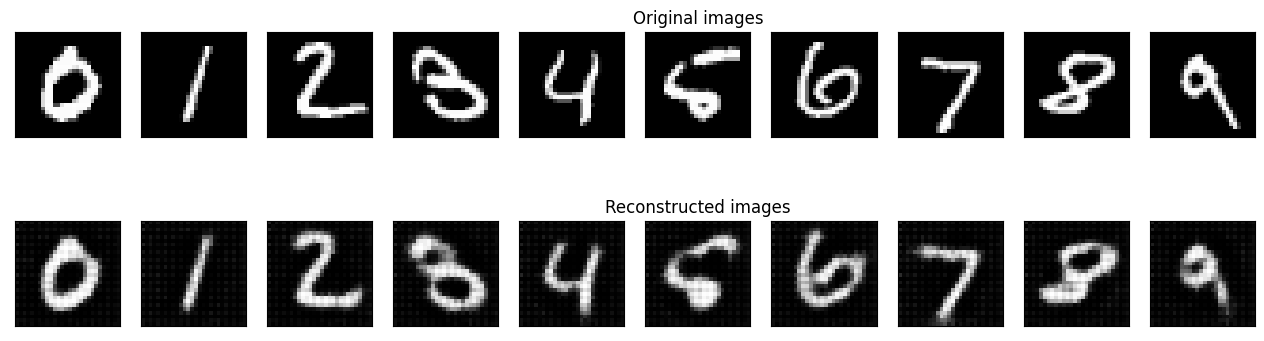

	 partial train loss (single batch): 0.013175
	 partial train loss (single batch): 0.012815
	 partial train loss (single batch): 0.012501
	 partial train loss (single batch): 0.013396
	 partial train loss (single batch): 0.013134
	 partial train loss (single batch): 0.012708
	 partial train loss (single batch): 0.012313
	 partial train loss (single batch): 0.013597
	 partial train loss (single batch): 0.012924
	 partial train loss (single batch): 0.013570
	 partial train loss (single batch): 0.012386
	 partial train loss (single batch): 0.012688
	 partial train loss (single batch): 0.012521
	 partial train loss (single batch): 0.012926
	 partial train loss (single batch): 0.012635
	 partial train loss (single batch): 0.012742
	 partial train loss (single batch): 0.013083
	 partial train loss (single batch): 0.012927
	 partial train loss (single batch): 0.013382
	 partial train loss (single batch): 0.012730
	 partial train loss (single batch): 0.012668
	 partial train loss (single batch

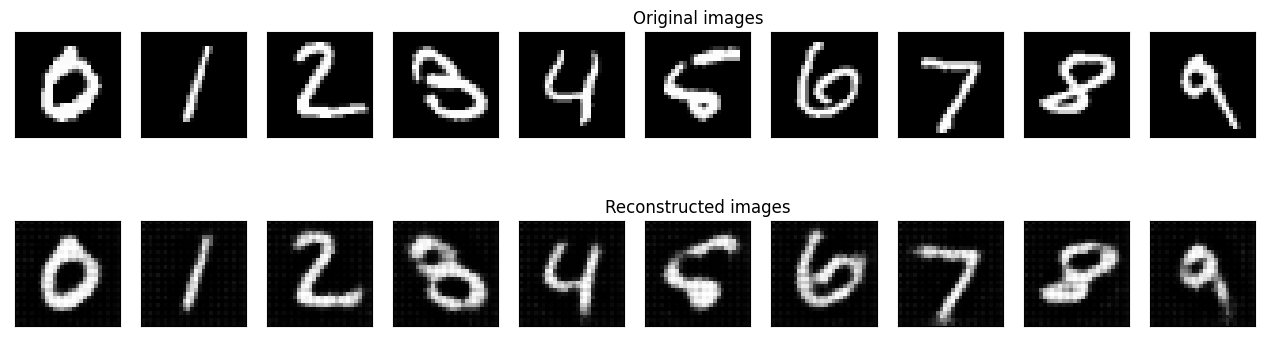

	 partial train loss (single batch): 0.011731
	 partial train loss (single batch): 0.011268
	 partial train loss (single batch): 0.011285
	 partial train loss (single batch): 0.011869
	 partial train loss (single batch): 0.011714
	 partial train loss (single batch): 0.011308
	 partial train loss (single batch): 0.010911
	 partial train loss (single batch): 0.012278
	 partial train loss (single batch): 0.011404
	 partial train loss (single batch): 0.012100
	 partial train loss (single batch): 0.011016
	 partial train loss (single batch): 0.011138
	 partial train loss (single batch): 0.011074
	 partial train loss (single batch): 0.011445
	 partial train loss (single batch): 0.011139
	 partial train loss (single batch): 0.011379
	 partial train loss (single batch): 0.011575
	 partial train loss (single batch): 0.011473
	 partial train loss (single batch): 0.011904
	 partial train loss (single batch): 0.011166
	 partial train loss (single batch): 0.011389
	 partial train loss (single batch

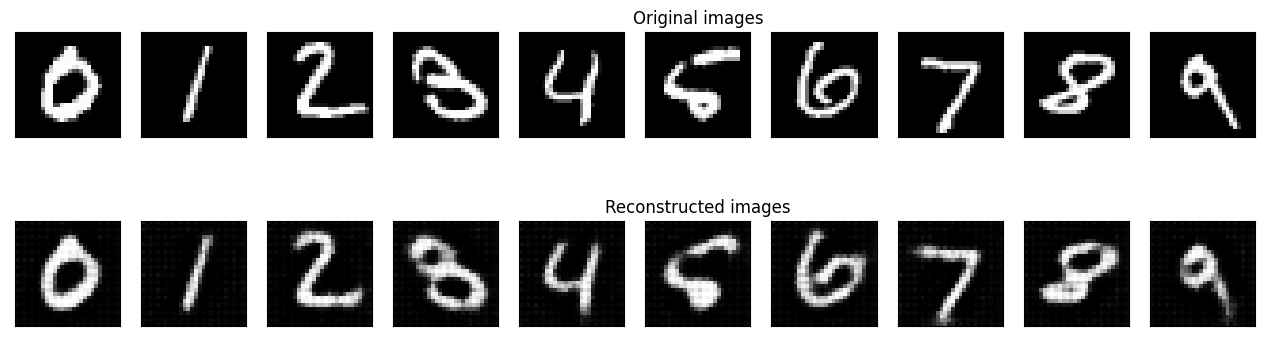

	 partial train loss (single batch): 0.010667
	 partial train loss (single batch): 0.010384
	 partial train loss (single batch): 0.010278
	 partial train loss (single batch): 0.010993
	 partial train loss (single batch): 0.010661
	 partial train loss (single batch): 0.010457
	 partial train loss (single batch): 0.010033
	 partial train loss (single batch): 0.011215
	 partial train loss (single batch): 0.010275
	 partial train loss (single batch): 0.011195
	 partial train loss (single batch): 0.010020
	 partial train loss (single batch): 0.010158
	 partial train loss (single batch): 0.010227
	 partial train loss (single batch): 0.010549
	 partial train loss (single batch): 0.010152
	 partial train loss (single batch): 0.010446
	 partial train loss (single batch): 0.010767
	 partial train loss (single batch): 0.010513
	 partial train loss (single batch): 0.010988
	 partial train loss (single batch): 0.010331
	 partial train loss (single batch): 0.010572
	 partial train loss (single batch

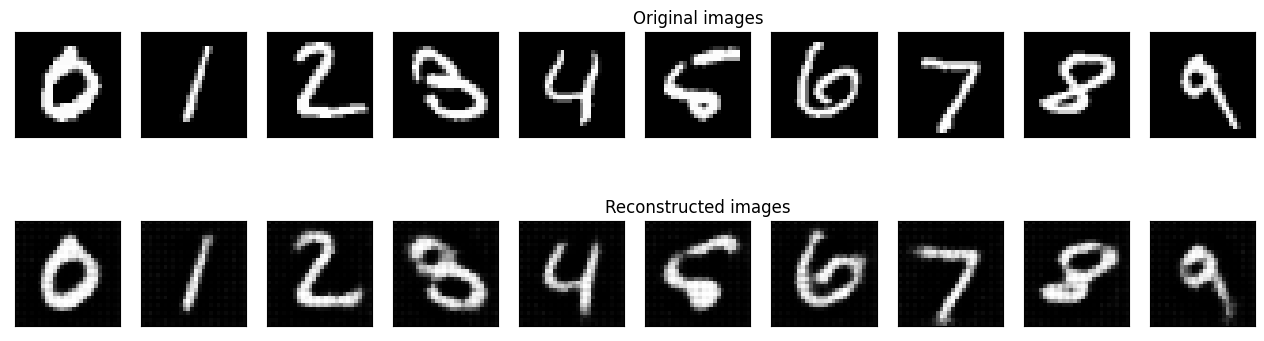

	 partial train loss (single batch): 0.010030
	 partial train loss (single batch): 0.009727
	 partial train loss (single batch): 0.009599
	 partial train loss (single batch): 0.010314
	 partial train loss (single batch): 0.010016
	 partial train loss (single batch): 0.009730
	 partial train loss (single batch): 0.009452
	 partial train loss (single batch): 0.010359
	 partial train loss (single batch): 0.009572
	 partial train loss (single batch): 0.010466
	 partial train loss (single batch): 0.009336
	 partial train loss (single batch): 0.009477
	 partial train loss (single batch): 0.009480
	 partial train loss (single batch): 0.009883
	 partial train loss (single batch): 0.009377
	 partial train loss (single batch): 0.009755
	 partial train loss (single batch): 0.009967
	 partial train loss (single batch): 0.009806
	 partial train loss (single batch): 0.010281
	 partial train loss (single batch): 0.009513
	 partial train loss (single batch): 0.009764
	 partial train loss (single batch

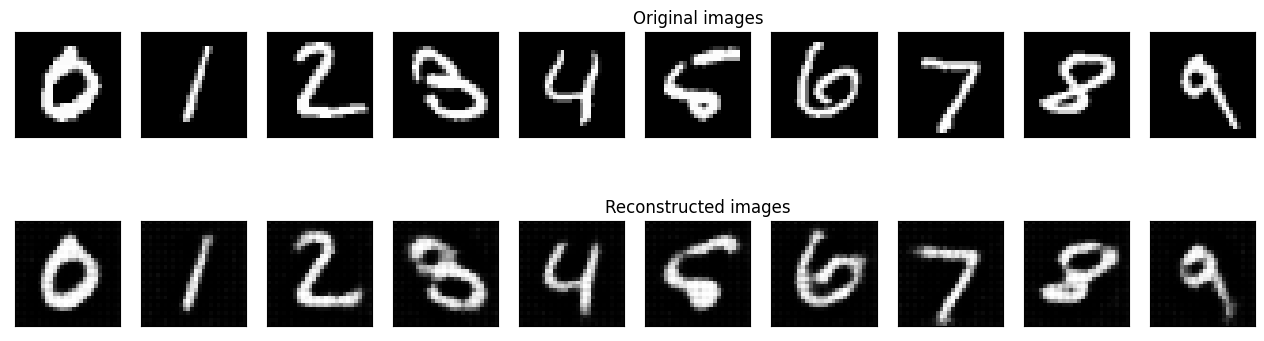

	 partial train loss (single batch): 0.009585
	 partial train loss (single batch): 0.009114
	 partial train loss (single batch): 0.009146
	 partial train loss (single batch): 0.009741
	 partial train loss (single batch): 0.009501
	 partial train loss (single batch): 0.009273
	 partial train loss (single batch): 0.008938
	 partial train loss (single batch): 0.009786
	 partial train loss (single batch): 0.009080
	 partial train loss (single batch): 0.009940
	 partial train loss (single batch): 0.008846
	 partial train loss (single batch): 0.008945
	 partial train loss (single batch): 0.008957
	 partial train loss (single batch): 0.009439
	 partial train loss (single batch): 0.008846
	 partial train loss (single batch): 0.009201
	 partial train loss (single batch): 0.009462
	 partial train loss (single batch): 0.009282
	 partial train loss (single batch): 0.009752
	 partial train loss (single batch): 0.009003
	 partial train loss (single batch): 0.009240
	 partial train loss (single batch

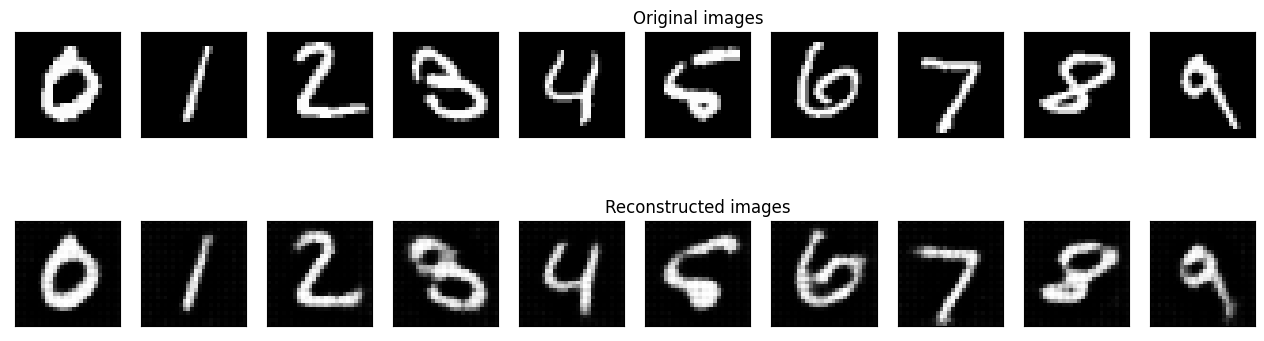

	 partial train loss (single batch): 0.009250
	 partial train loss (single batch): 0.008748
	 partial train loss (single batch): 0.008767
	 partial train loss (single batch): 0.009322
	 partial train loss (single batch): 0.009137
	 partial train loss (single batch): 0.008927
	 partial train loss (single batch): 0.008618
	 partial train loss (single batch): 0.009441
	 partial train loss (single batch): 0.008755
	 partial train loss (single batch): 0.009536
	 partial train loss (single batch): 0.008568
	 partial train loss (single batch): 0.008559
	 partial train loss (single batch): 0.008598
	 partial train loss (single batch): 0.009106
	 partial train loss (single batch): 0.008504
	 partial train loss (single batch): 0.008864
	 partial train loss (single batch): 0.009085
	 partial train loss (single batch): 0.008933
	 partial train loss (single batch): 0.009421
	 partial train loss (single batch): 0.008627
	 partial train loss (single batch): 0.008894
	 partial train loss (single batch

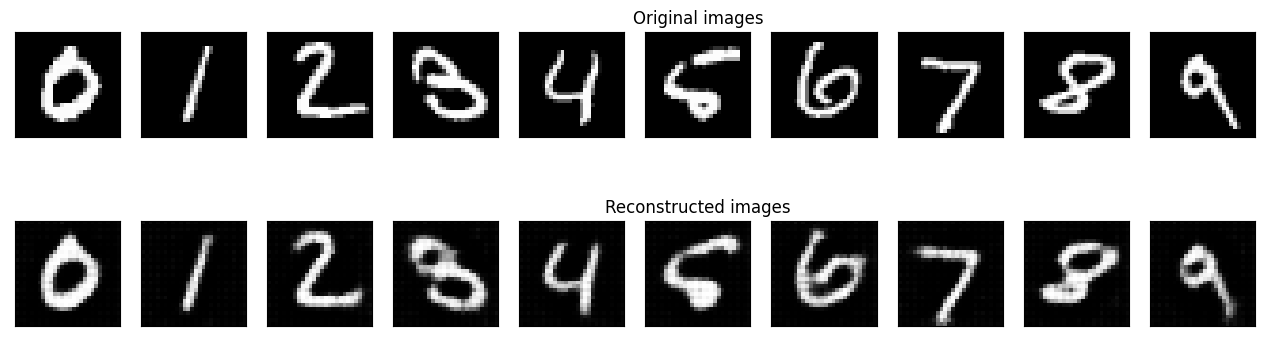

	 partial train loss (single batch): 0.008946
	 partial train loss (single batch): 0.008529
	 partial train loss (single batch): 0.008387
	 partial train loss (single batch): 0.009079
	 partial train loss (single batch): 0.008868
	 partial train loss (single batch): 0.008605
	 partial train loss (single batch): 0.008420
	 partial train loss (single batch): 0.009164
	 partial train loss (single batch): 0.008420
	 partial train loss (single batch): 0.009360
	 partial train loss (single batch): 0.008320
	 partial train loss (single batch): 0.008338
	 partial train loss (single batch): 0.008393
	 partial train loss (single batch): 0.008767
	 partial train loss (single batch): 0.008283
	 partial train loss (single batch): 0.008520
	 partial train loss (single batch): 0.008790
	 partial train loss (single batch): 0.008624
	 partial train loss (single batch): 0.009091
	 partial train loss (single batch): 0.008331
	 partial train loss (single batch): 0.008546
	 partial train loss (single batch

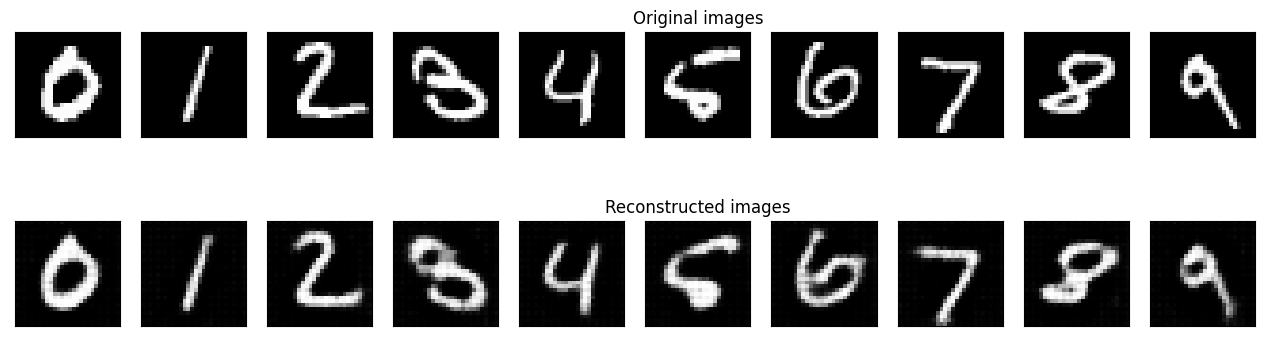

	 partial train loss (single batch): 0.008624
	 partial train loss (single batch): 0.008125
	 partial train loss (single batch): 0.008015
	 partial train loss (single batch): 0.008677
	 partial train loss (single batch): 0.008495
	 partial train loss (single batch): 0.008301
	 partial train loss (single batch): 0.008101
	 partial train loss (single batch): 0.008839
	 partial train loss (single batch): 0.008120
	 partial train loss (single batch): 0.009040
	 partial train loss (single batch): 0.008017
	 partial train loss (single batch): 0.008029
	 partial train loss (single batch): 0.008058
	 partial train loss (single batch): 0.008463
	 partial train loss (single batch): 0.008002
	 partial train loss (single batch): 0.008212
	 partial train loss (single batch): 0.008536
	 partial train loss (single batch): 0.008346
	 partial train loss (single batch): 0.008829
	 partial train loss (single batch): 0.008034
	 partial train loss (single batch): 0.008275
	 partial train loss (single batch

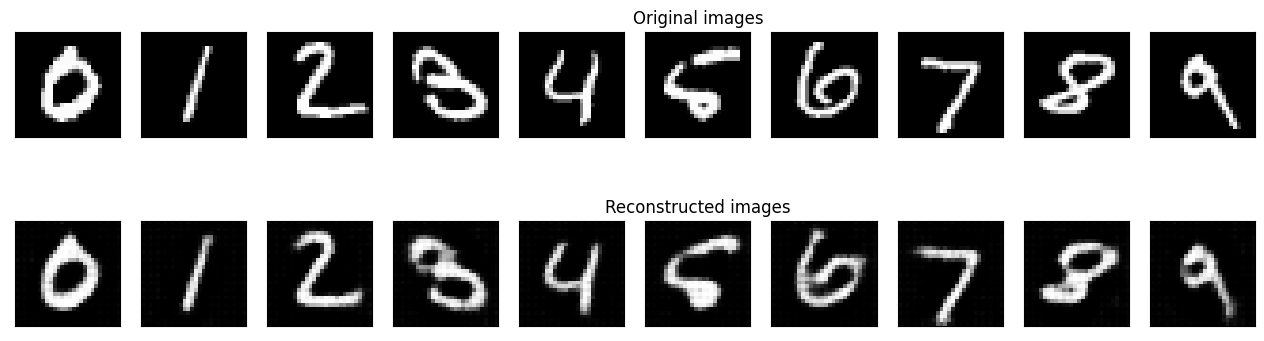

	 partial train loss (single batch): 0.008447
	 partial train loss (single batch): 0.008123
	 partial train loss (single batch): 0.007838
	 partial train loss (single batch): 0.008615
	 partial train loss (single batch): 0.008394
	 partial train loss (single batch): 0.008188
	 partial train loss (single batch): 0.007889
	 partial train loss (single batch): 0.008698
	 partial train loss (single batch): 0.008000
	 partial train loss (single batch): 0.008785
	 partial train loss (single batch): 0.007904
	 partial train loss (single batch): 0.007888
	 partial train loss (single batch): 0.007848
	 partial train loss (single batch): 0.008345
	 partial train loss (single batch): 0.007804
	 partial train loss (single batch): 0.008141
	 partial train loss (single batch): 0.008369
	 partial train loss (single batch): 0.008201
	 partial train loss (single batch): 0.008697
	 partial train loss (single batch): 0.007894
	 partial train loss (single batch): 0.008065
	 partial train loss (single batch

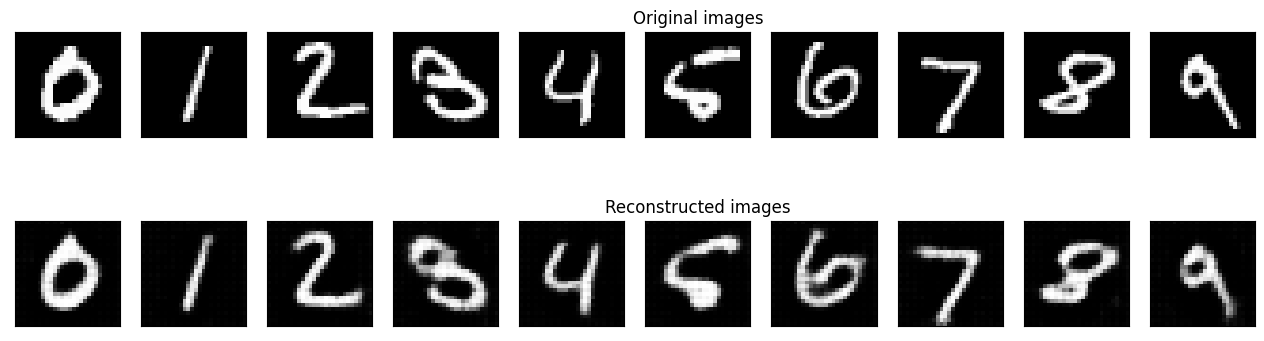

	 partial train loss (single batch): 0.008290
	 partial train loss (single batch): 0.007660
	 partial train loss (single batch): 0.007572
	 partial train loss (single batch): 0.008282
	 partial train loss (single batch): 0.008031
	 partial train loss (single batch): 0.007849
	 partial train loss (single batch): 0.007668
	 partial train loss (single batch): 0.008393
	 partial train loss (single batch): 0.007756
	 partial train loss (single batch): 0.008595
	 partial train loss (single batch): 0.007693
	 partial train loss (single batch): 0.007666
	 partial train loss (single batch): 0.007642
	 partial train loss (single batch): 0.008084
	 partial train loss (single batch): 0.007650
	 partial train loss (single batch): 0.007858
	 partial train loss (single batch): 0.008122
	 partial train loss (single batch): 0.007971
	 partial train loss (single batch): 0.008389
	 partial train loss (single batch): 0.007616
	 partial train loss (single batch): 0.007842
	 partial train loss (single batch

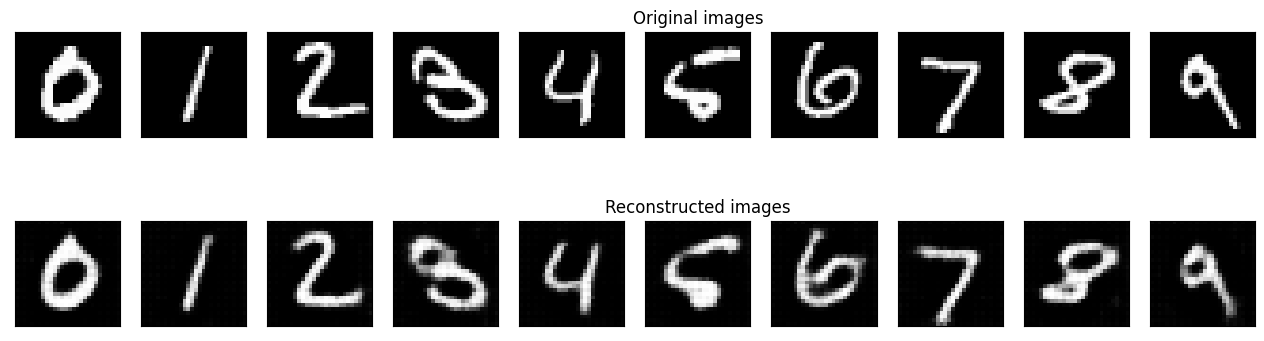

	 partial train loss (single batch): 0.008237
	 partial train loss (single batch): 0.007561
	 partial train loss (single batch): 0.007492
	 partial train loss (single batch): 0.008208
	 partial train loss (single batch): 0.007907
	 partial train loss (single batch): 0.007744
	 partial train loss (single batch): 0.007539
	 partial train loss (single batch): 0.008313
	 partial train loss (single batch): 0.007526
	 partial train loss (single batch): 0.008412
	 partial train loss (single batch): 0.007516
	 partial train loss (single batch): 0.007483
	 partial train loss (single batch): 0.007475
	 partial train loss (single batch): 0.007948
	 partial train loss (single batch): 0.007500
	 partial train loss (single batch): 0.007684
	 partial train loss (single batch): 0.008028
	 partial train loss (single batch): 0.007829
	 partial train loss (single batch): 0.008222
	 partial train loss (single batch): 0.007465
	 partial train loss (single batch): 0.007693
	 partial train loss (single batch

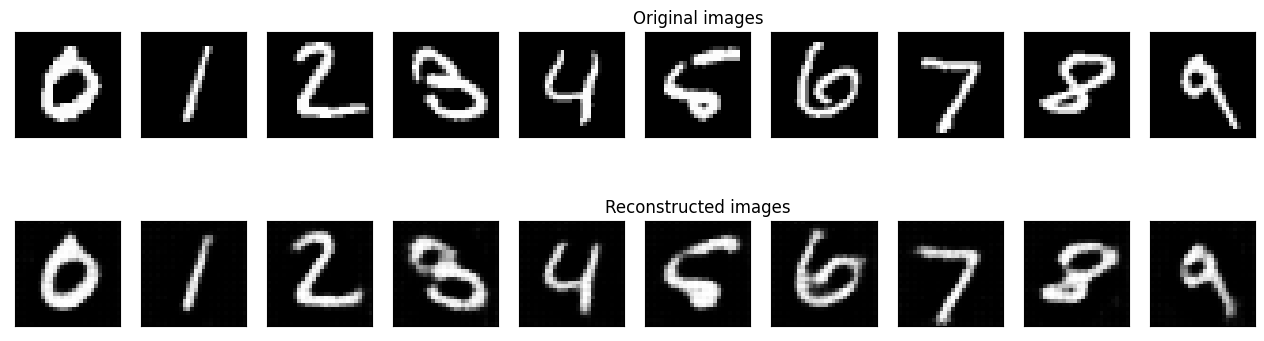

	 partial train loss (single batch): 0.007937
	 partial train loss (single batch): 0.007373
	 partial train loss (single batch): 0.007246
	 partial train loss (single batch): 0.007990
	 partial train loss (single batch): 0.007661
	 partial train loss (single batch): 0.007480
	 partial train loss (single batch): 0.007374
	 partial train loss (single batch): 0.008044
	 partial train loss (single batch): 0.007368
	 partial train loss (single batch): 0.008192
	 partial train loss (single batch): 0.007370
	 partial train loss (single batch): 0.007207
	 partial train loss (single batch): 0.007328
	 partial train loss (single batch): 0.007742
	 partial train loss (single batch): 0.007301
	 partial train loss (single batch): 0.007459
	 partial train loss (single batch): 0.007789
	 partial train loss (single batch): 0.007682
	 partial train loss (single batch): 0.007965
	 partial train loss (single batch): 0.007246
	 partial train loss (single batch): 0.007477
	 partial train loss (single batch

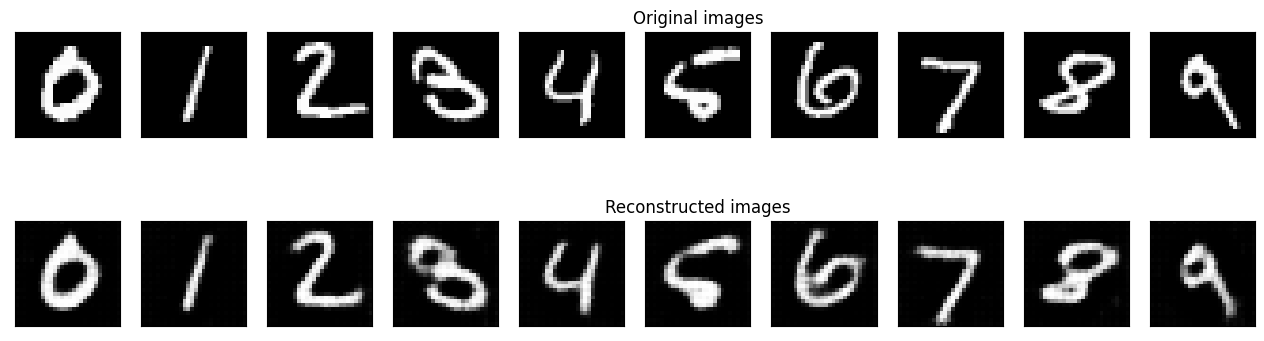

	 partial train loss (single batch): 0.007819
	 partial train loss (single batch): 0.007214
	 partial train loss (single batch): 0.007128
	 partial train loss (single batch): 0.007827
	 partial train loss (single batch): 0.007500
	 partial train loss (single batch): 0.007375
	 partial train loss (single batch): 0.007229
	 partial train loss (single batch): 0.007928
	 partial train loss (single batch): 0.007220
	 partial train loss (single batch): 0.008075
	 partial train loss (single batch): 0.007207
	 partial train loss (single batch): 0.007041
	 partial train loss (single batch): 0.007245
	 partial train loss (single batch): 0.007562
	 partial train loss (single batch): 0.007168
	 partial train loss (single batch): 0.007267
	 partial train loss (single batch): 0.007614
	 partial train loss (single batch): 0.007495
	 partial train loss (single batch): 0.007780
	 partial train loss (single batch): 0.007130
	 partial train loss (single batch): 0.007280
	 partial train loss (single batch

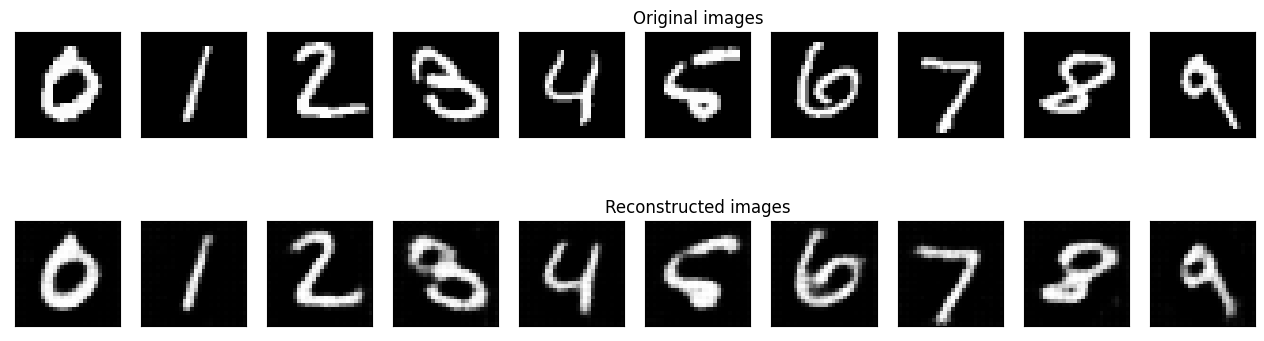

	 partial train loss (single batch): 0.007703
	 partial train loss (single batch): 0.007105
	 partial train loss (single batch): 0.007018
	 partial train loss (single batch): 0.007681
	 partial train loss (single batch): 0.007421
	 partial train loss (single batch): 0.007242
	 partial train loss (single batch): 0.007155
	 partial train loss (single batch): 0.007762
	 partial train loss (single batch): 0.007094
	 partial train loss (single batch): 0.007965
	 partial train loss (single batch): 0.007081
	 partial train loss (single batch): 0.006926
	 partial train loss (single batch): 0.007131
	 partial train loss (single batch): 0.007416
	 partial train loss (single batch): 0.007044
	 partial train loss (single batch): 0.007111
	 partial train loss (single batch): 0.007463
	 partial train loss (single batch): 0.007379
	 partial train loss (single batch): 0.007676
	 partial train loss (single batch): 0.007035
	 partial train loss (single batch): 0.007190
	 partial train loss (single batch

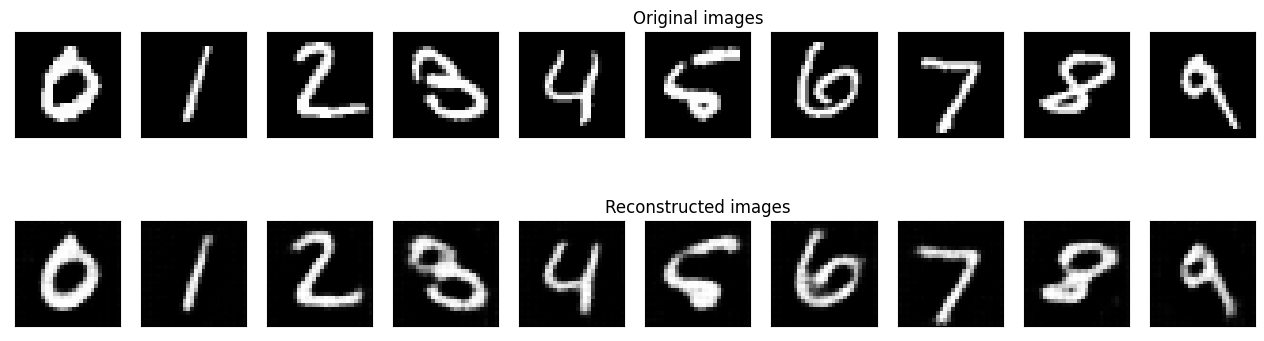

	 partial train loss (single batch): 0.007381
	 partial train loss (single batch): 0.007009
	 partial train loss (single batch): 0.006800
	 partial train loss (single batch): 0.007509
	 partial train loss (single batch): 0.007242
	 partial train loss (single batch): 0.007115
	 partial train loss (single batch): 0.007006
	 partial train loss (single batch): 0.007649
	 partial train loss (single batch): 0.006934
	 partial train loss (single batch): 0.007827
	 partial train loss (single batch): 0.006905
	 partial train loss (single batch): 0.006902
	 partial train loss (single batch): 0.006915
	 partial train loss (single batch): 0.007290
	 partial train loss (single batch): 0.006900
	 partial train loss (single batch): 0.007000
	 partial train loss (single batch): 0.007324
	 partial train loss (single batch): 0.007272
	 partial train loss (single batch): 0.007583
	 partial train loss (single batch): 0.006980
	 partial train loss (single batch): 0.007057
	 partial train loss (single batch

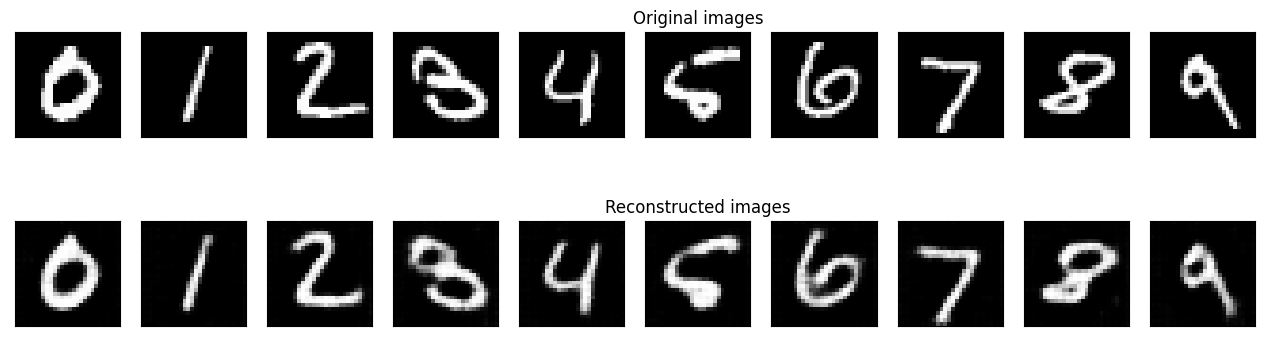

	 partial train loss (single batch): 0.007251
	 partial train loss (single batch): 0.006853
	 partial train loss (single batch): 0.006647
	 partial train loss (single batch): 0.007424
	 partial train loss (single batch): 0.007123
	 partial train loss (single batch): 0.006953
	 partial train loss (single batch): 0.006891
	 partial train loss (single batch): 0.007488
	 partial train loss (single batch): 0.006862
	 partial train loss (single batch): 0.007664
	 partial train loss (single batch): 0.006848
	 partial train loss (single batch): 0.006747
	 partial train loss (single batch): 0.006864
	 partial train loss (single batch): 0.007147
	 partial train loss (single batch): 0.006820
	 partial train loss (single batch): 0.006902
	 partial train loss (single batch): 0.007207
	 partial train loss (single batch): 0.007192
	 partial train loss (single batch): 0.007423
	 partial train loss (single batch): 0.006849
	 partial train loss (single batch): 0.006954
	 partial train loss (single batch

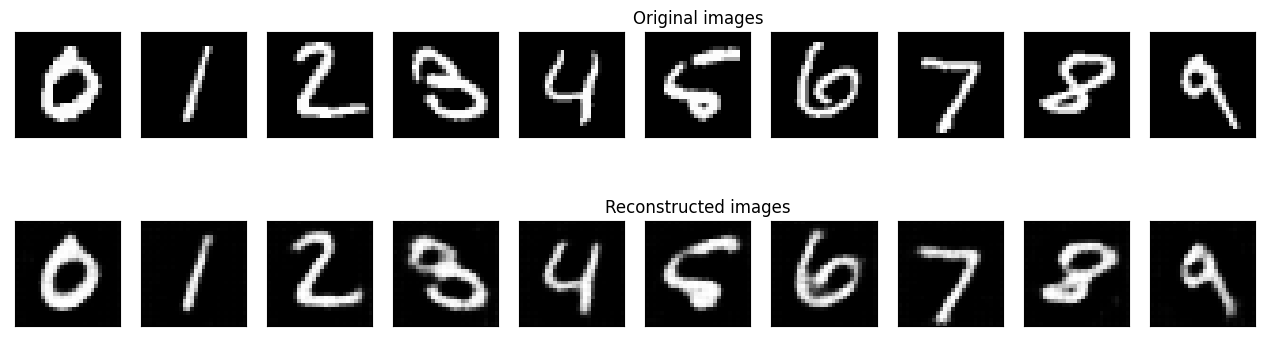

	 partial train loss (single batch): 0.007074
	 partial train loss (single batch): 0.006737
	 partial train loss (single batch): 0.006555
	 partial train loss (single batch): 0.007473
	 partial train loss (single batch): 0.007244
	 partial train loss (single batch): 0.006851
	 partial train loss (single batch): 0.006989
	 partial train loss (single batch): 0.007545
	 partial train loss (single batch): 0.006826
	 partial train loss (single batch): 0.007620
	 partial train loss (single batch): 0.006856
	 partial train loss (single batch): 0.006722
	 partial train loss (single batch): 0.006751
	 partial train loss (single batch): 0.007118
	 partial train loss (single batch): 0.006707
	 partial train loss (single batch): 0.006852
	 partial train loss (single batch): 0.007243
	 partial train loss (single batch): 0.006996
	 partial train loss (single batch): 0.007441
	 partial train loss (single batch): 0.006749
	 partial train loss (single batch): 0.006786
	 partial train loss (single batch

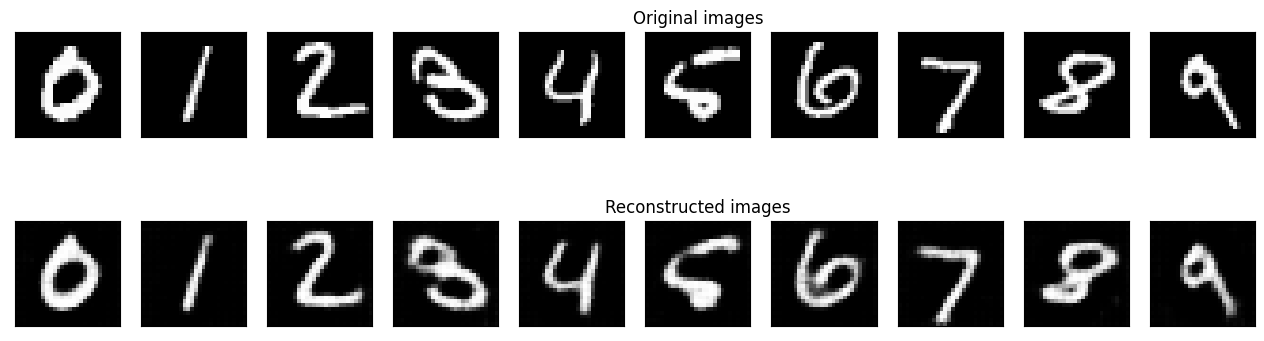

	 partial train loss (single batch): 0.007031
	 partial train loss (single batch): 0.006723
	 partial train loss (single batch): 0.006473
	 partial train loss (single batch): 0.007264
	 partial train loss (single batch): 0.006926
	 partial train loss (single batch): 0.006717
	 partial train loss (single batch): 0.006750
	 partial train loss (single batch): 0.007201
	 partial train loss (single batch): 0.006652
	 partial train loss (single batch): 0.007449
	 partial train loss (single batch): 0.006667
	 partial train loss (single batch): 0.006613
	 partial train loss (single batch): 0.006665
	 partial train loss (single batch): 0.007068
	 partial train loss (single batch): 0.006652
	 partial train loss (single batch): 0.006781
	 partial train loss (single batch): 0.007065
	 partial train loss (single batch): 0.006944
	 partial train loss (single batch): 0.007369
	 partial train loss (single batch): 0.006609
	 partial train loss (single batch): 0.006730
	 partial train loss (single batch

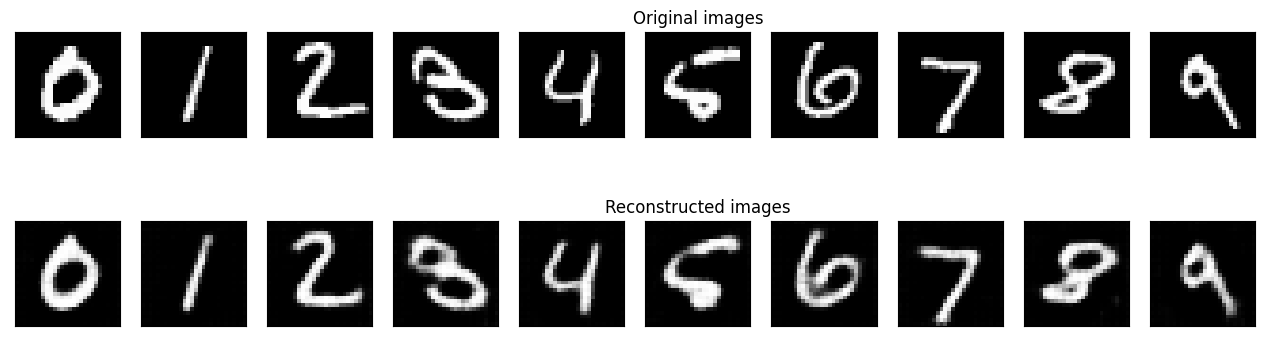

	 partial train loss (single batch): 0.006848
	 partial train loss (single batch): 0.006529
	 partial train loss (single batch): 0.006335
	 partial train loss (single batch): 0.007063
	 partial train loss (single batch): 0.006810
	 partial train loss (single batch): 0.006589
	 partial train loss (single batch): 0.006581
	 partial train loss (single batch): 0.007127
	 partial train loss (single batch): 0.006510
	 partial train loss (single batch): 0.007318
	 partial train loss (single batch): 0.006529
	 partial train loss (single batch): 0.006493
	 partial train loss (single batch): 0.006492
	 partial train loss (single batch): 0.006884
	 partial train loss (single batch): 0.006521
	 partial train loss (single batch): 0.006577
	 partial train loss (single batch): 0.006932
	 partial train loss (single batch): 0.006815
	 partial train loss (single batch): 0.007194
	 partial train loss (single batch): 0.006482
	 partial train loss (single batch): 0.006667
	 partial train loss (single batch

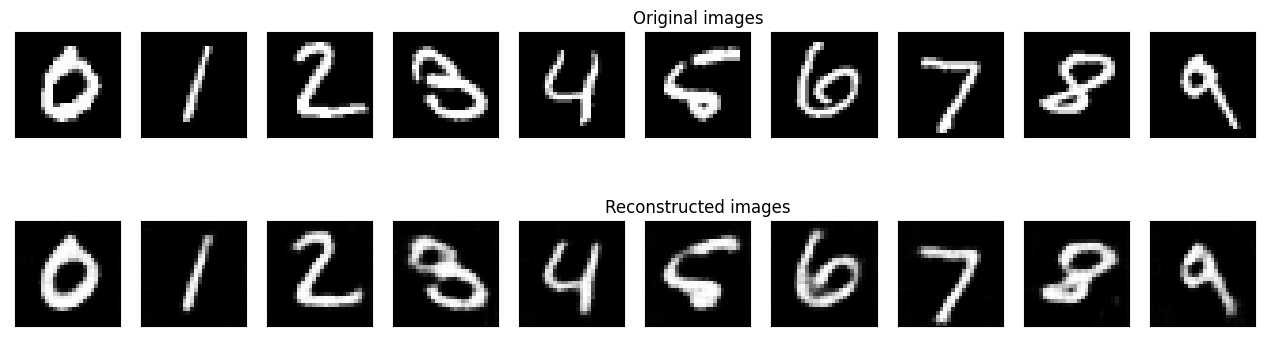

	 partial train loss (single batch): 0.006796
	 partial train loss (single batch): 0.006469
	 partial train loss (single batch): 0.006294
	 partial train loss (single batch): 0.007006
	 partial train loss (single batch): 0.006748
	 partial train loss (single batch): 0.006531
	 partial train loss (single batch): 0.006543
	 partial train loss (single batch): 0.007069
	 partial train loss (single batch): 0.006464
	 partial train loss (single batch): 0.007270
	 partial train loss (single batch): 0.006489
	 partial train loss (single batch): 0.006442
	 partial train loss (single batch): 0.006447
	 partial train loss (single batch): 0.006793
	 partial train loss (single batch): 0.006472
	 partial train loss (single batch): 0.006493
	 partial train loss (single batch): 0.006858
	 partial train loss (single batch): 0.006729
	 partial train loss (single batch): 0.007112
	 partial train loss (single batch): 0.006378
	 partial train loss (single batch): 0.006590
	 partial train loss (single batch

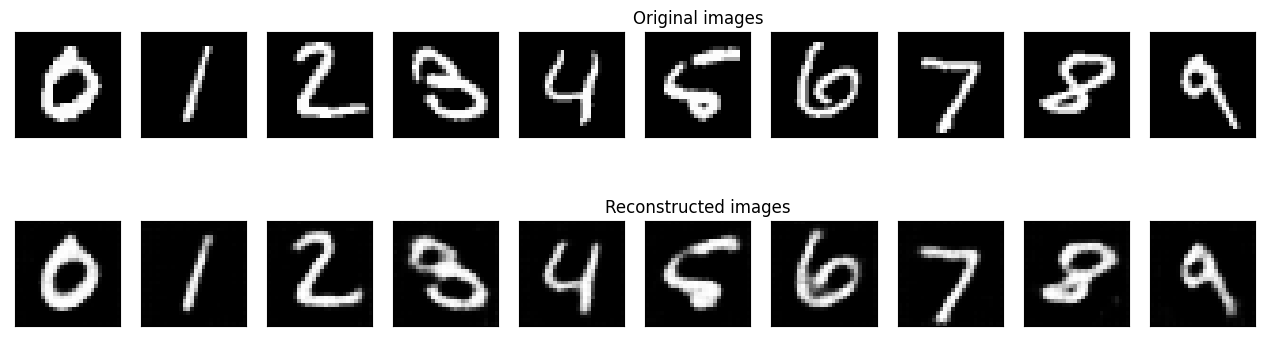

	 partial train loss (single batch): 0.006723
	 partial train loss (single batch): 0.006393
	 partial train loss (single batch): 0.006240
	 partial train loss (single batch): 0.006925
	 partial train loss (single batch): 0.006685
	 partial train loss (single batch): 0.006453
	 partial train loss (single batch): 0.006468
	 partial train loss (single batch): 0.006979
	 partial train loss (single batch): 0.006387
	 partial train loss (single batch): 0.007182
	 partial train loss (single batch): 0.006412
	 partial train loss (single batch): 0.006368
	 partial train loss (single batch): 0.006377
	 partial train loss (single batch): 0.006695
	 partial train loss (single batch): 0.006383
	 partial train loss (single batch): 0.006415
	 partial train loss (single batch): 0.006768
	 partial train loss (single batch): 0.006648
	 partial train loss (single batch): 0.007028
	 partial train loss (single batch): 0.006295
	 partial train loss (single batch): 0.006521
	 partial train loss (single batch

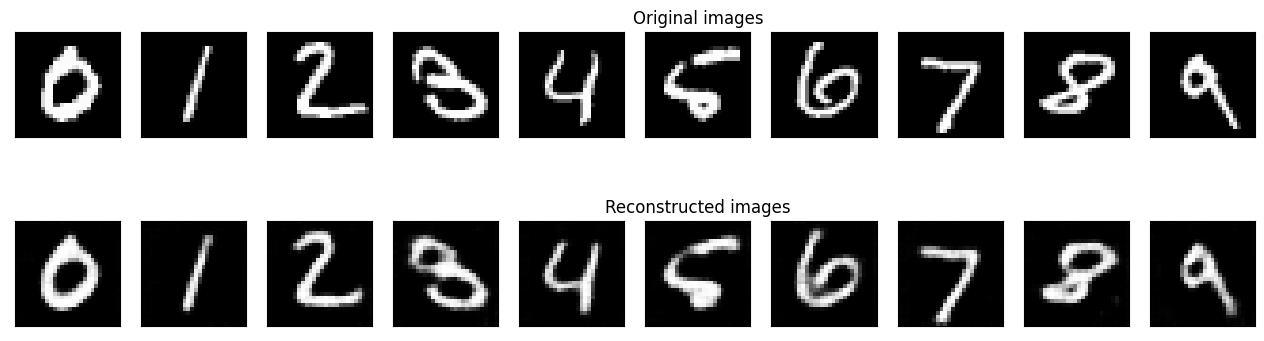

	 partial train loss (single batch): 0.006650
	 partial train loss (single batch): 0.006336
	 partial train loss (single batch): 0.006190
	 partial train loss (single batch): 0.006848
	 partial train loss (single batch): 0.006640
	 partial train loss (single batch): 0.006356
	 partial train loss (single batch): 0.006426
	 partial train loss (single batch): 0.006896
	 partial train loss (single batch): 0.006298
	 partial train loss (single batch): 0.007126
	 partial train loss (single batch): 0.006342
	 partial train loss (single batch): 0.006321
	 partial train loss (single batch): 0.006331
	 partial train loss (single batch): 0.006647
	 partial train loss (single batch): 0.006346
	 partial train loss (single batch): 0.006371
	 partial train loss (single batch): 0.006725
	 partial train loss (single batch): 0.006571
	 partial train loss (single batch): 0.006978
	 partial train loss (single batch): 0.006210
	 partial train loss (single batch): 0.006471
	 partial train loss (single batch

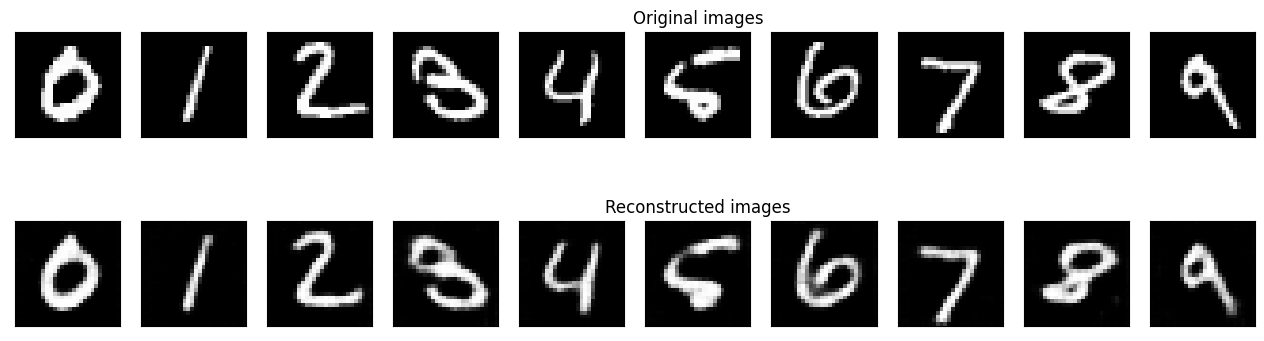

	 partial train loss (single batch): 0.006720
	 partial train loss (single batch): 0.006422
	 partial train loss (single batch): 0.006330
	 partial train loss (single batch): 0.006858
	 partial train loss (single batch): 0.006643
	 partial train loss (single batch): 0.006423
	 partial train loss (single batch): 0.006458
	 partial train loss (single batch): 0.006859
	 partial train loss (single batch): 0.006398
	 partial train loss (single batch): 0.007213
	 partial train loss (single batch): 0.006446
	 partial train loss (single batch): 0.006394
	 partial train loss (single batch): 0.006385
	 partial train loss (single batch): 0.006811
	 partial train loss (single batch): 0.006400
	 partial train loss (single batch): 0.006536
	 partial train loss (single batch): 0.006769
	 partial train loss (single batch): 0.006700
	 partial train loss (single batch): 0.007058
	 partial train loss (single batch): 0.006275
	 partial train loss (single batch): 0.006464
	 partial train loss (single batch

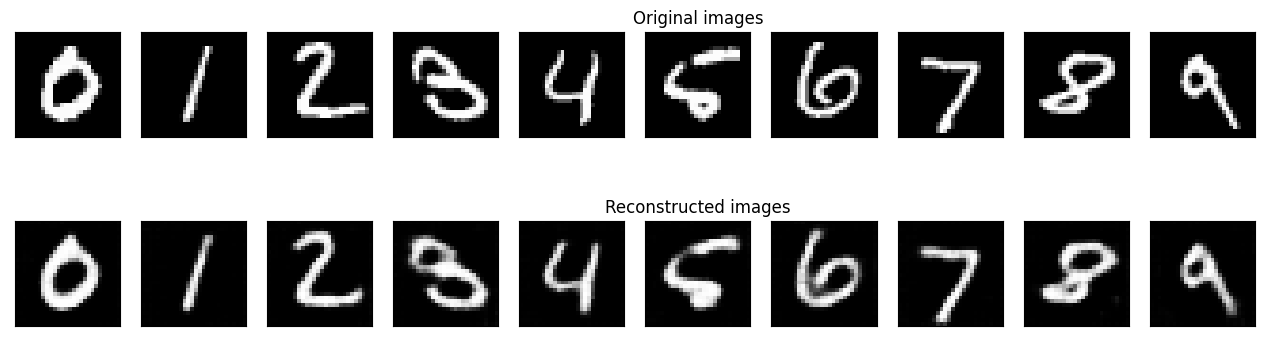

	 partial train loss (single batch): 0.006547
	 partial train loss (single batch): 0.006154
	 partial train loss (single batch): 0.006109
	 partial train loss (single batch): 0.006692
	 partial train loss (single batch): 0.006439
	 partial train loss (single batch): 0.006210
	 partial train loss (single batch): 0.006302
	 partial train loss (single batch): 0.006702
	 partial train loss (single batch): 0.006168
	 partial train loss (single batch): 0.007026
	 partial train loss (single batch): 0.006262
	 partial train loss (single batch): 0.006251
	 partial train loss (single batch): 0.006229
	 partial train loss (single batch): 0.006574
	 partial train loss (single batch): 0.006224
	 partial train loss (single batch): 0.006299
	 partial train loss (single batch): 0.006598
	 partial train loss (single batch): 0.006456
	 partial train loss (single batch): 0.006873
	 partial train loss (single batch): 0.006078
	 partial train loss (single batch): 0.006300
	 partial train loss (single batch

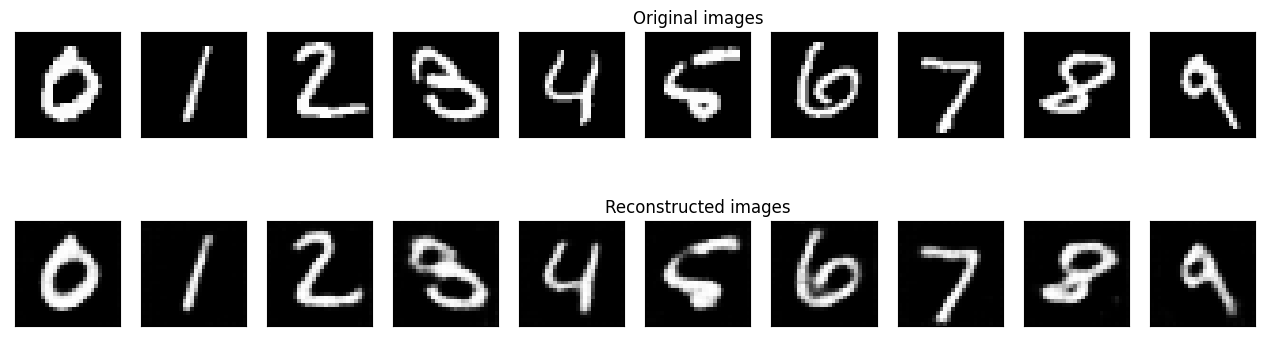

	 partial train loss (single batch): 0.006470
	 partial train loss (single batch): 0.006108
	 partial train loss (single batch): 0.006050
	 partial train loss (single batch): 0.006637
	 partial train loss (single batch): 0.006386
	 partial train loss (single batch): 0.006167
	 partial train loss (single batch): 0.006218
	 partial train loss (single batch): 0.006660
	 partial train loss (single batch): 0.006095
	 partial train loss (single batch): 0.006963
	 partial train loss (single batch): 0.006171
	 partial train loss (single batch): 0.006191
	 partial train loss (single batch): 0.006187
	 partial train loss (single batch): 0.006486
	 partial train loss (single batch): 0.006186
	 partial train loss (single batch): 0.006254
	 partial train loss (single batch): 0.006504
	 partial train loss (single batch): 0.006418
	 partial train loss (single batch): 0.006775
	 partial train loss (single batch): 0.006002
	 partial train loss (single batch): 0.006254
	 partial train loss (single batch

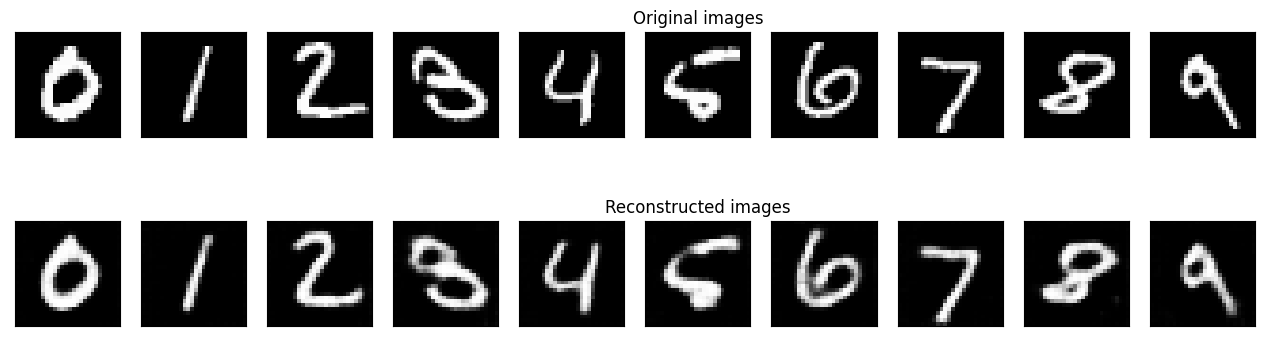

	 partial train loss (single batch): 0.006407
	 partial train loss (single batch): 0.006061
	 partial train loss (single batch): 0.006006
	 partial train loss (single batch): 0.006585
	 partial train loss (single batch): 0.006343
	 partial train loss (single batch): 0.006129
	 partial train loss (single batch): 0.006154
	 partial train loss (single batch): 0.006620
	 partial train loss (single batch): 0.006064
	 partial train loss (single batch): 0.006894
	 partial train loss (single batch): 0.006108
	 partial train loss (single batch): 0.006108
	 partial train loss (single batch): 0.006148
	 partial train loss (single batch): 0.006401
	 partial train loss (single batch): 0.006127
	 partial train loss (single batch): 0.006205
	 partial train loss (single batch): 0.006404
	 partial train loss (single batch): 0.006393
	 partial train loss (single batch): 0.006686
	 partial train loss (single batch): 0.005936
	 partial train loss (single batch): 0.006215
	 partial train loss (single batch

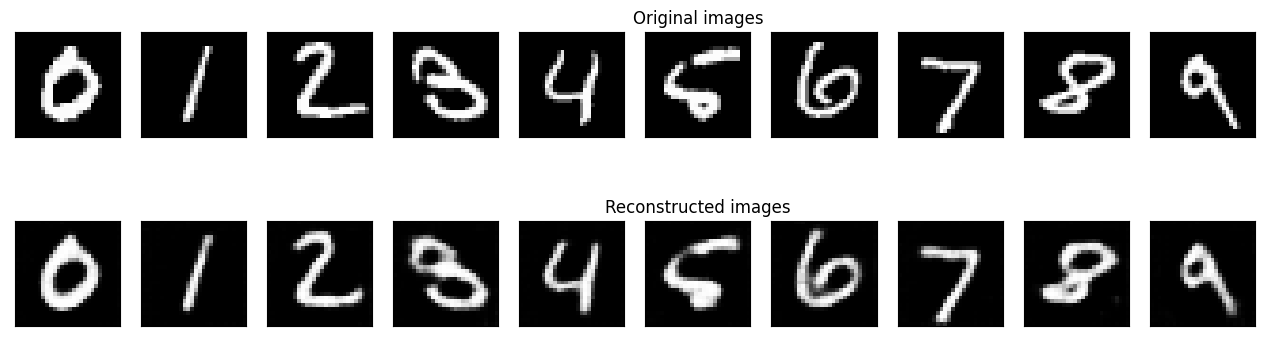

	 partial train loss (single batch): 0.006361
	 partial train loss (single batch): 0.006045
	 partial train loss (single batch): 0.005970
	 partial train loss (single batch): 0.006582
	 partial train loss (single batch): 0.006310
	 partial train loss (single batch): 0.006093
	 partial train loss (single batch): 0.006114
	 partial train loss (single batch): 0.006564
	 partial train loss (single batch): 0.006012
	 partial train loss (single batch): 0.006843
	 partial train loss (single batch): 0.006066
	 partial train loss (single batch): 0.006088
	 partial train loss (single batch): 0.006115
	 partial train loss (single batch): 0.006359
	 partial train loss (single batch): 0.006103
	 partial train loss (single batch): 0.006143
	 partial train loss (single batch): 0.006361
	 partial train loss (single batch): 0.006350
	 partial train loss (single batch): 0.006612
	 partial train loss (single batch): 0.005917
	 partial train loss (single batch): 0.006167
	 partial train loss (single batch

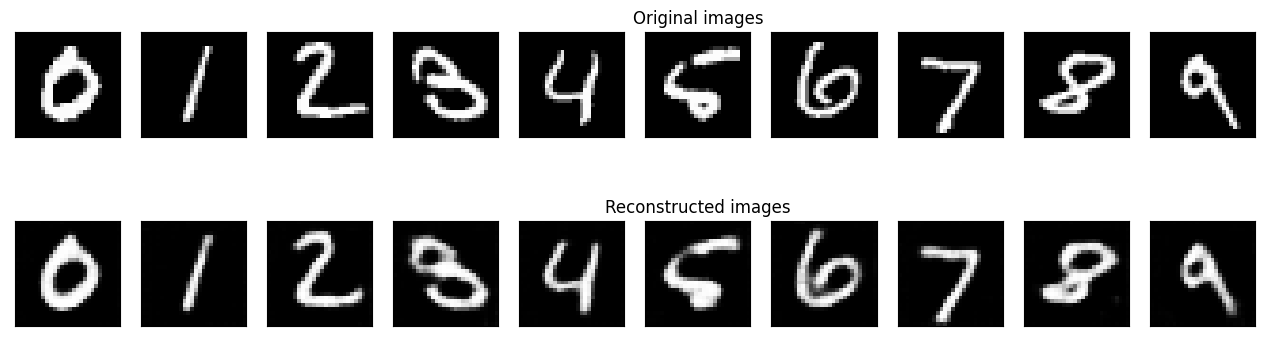

	 partial train loss (single batch): 0.006311
	 partial train loss (single batch): 0.006017
	 partial train loss (single batch): 0.005929
	 partial train loss (single batch): 0.006552
	 partial train loss (single batch): 0.006255
	 partial train loss (single batch): 0.006068
	 partial train loss (single batch): 0.006068
	 partial train loss (single batch): 0.006522
	 partial train loss (single batch): 0.005984
	 partial train loss (single batch): 0.006819
	 partial train loss (single batch): 0.006025
	 partial train loss (single batch): 0.006088
	 partial train loss (single batch): 0.006100
	 partial train loss (single batch): 0.006334
	 partial train loss (single batch): 0.006086
	 partial train loss (single batch): 0.006117
	 partial train loss (single batch): 0.006335
	 partial train loss (single batch): 0.006301
	 partial train loss (single batch): 0.006561
	 partial train loss (single batch): 0.005898
	 partial train loss (single batch): 0.006088
	 partial train loss (single batch

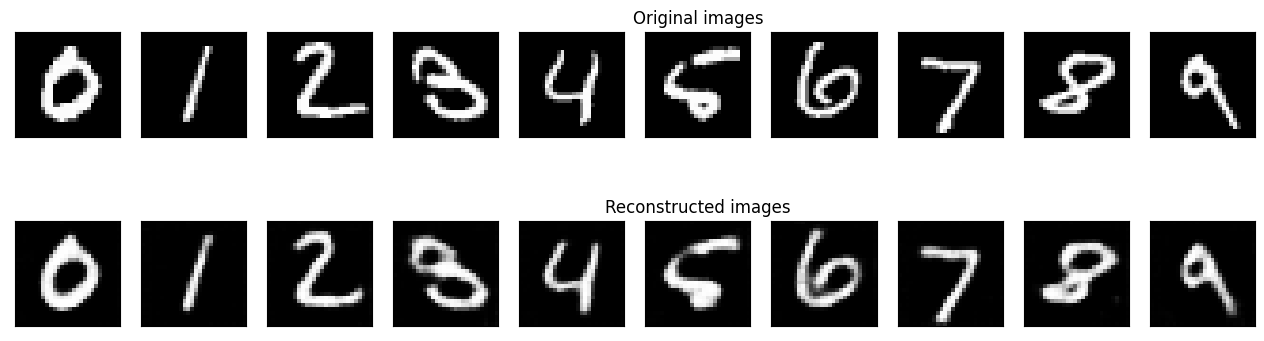

	 partial train loss (single batch): 0.006273
	 partial train loss (single batch): 0.005972
	 partial train loss (single batch): 0.005894
	 partial train loss (single batch): 0.006498
	 partial train loss (single batch): 0.006215
	 partial train loss (single batch): 0.006031
	 partial train loss (single batch): 0.006015
	 partial train loss (single batch): 0.006484
	 partial train loss (single batch): 0.005967
	 partial train loss (single batch): 0.006767
	 partial train loss (single batch): 0.005979
	 partial train loss (single batch): 0.006046
	 partial train loss (single batch): 0.006062
	 partial train loss (single batch): 0.006299
	 partial train loss (single batch): 0.006026
	 partial train loss (single batch): 0.006082
	 partial train loss (single batch): 0.006277
	 partial train loss (single batch): 0.006253
	 partial train loss (single batch): 0.006514
	 partial train loss (single batch): 0.005847
	 partial train loss (single batch): 0.006011
	 partial train loss (single batch

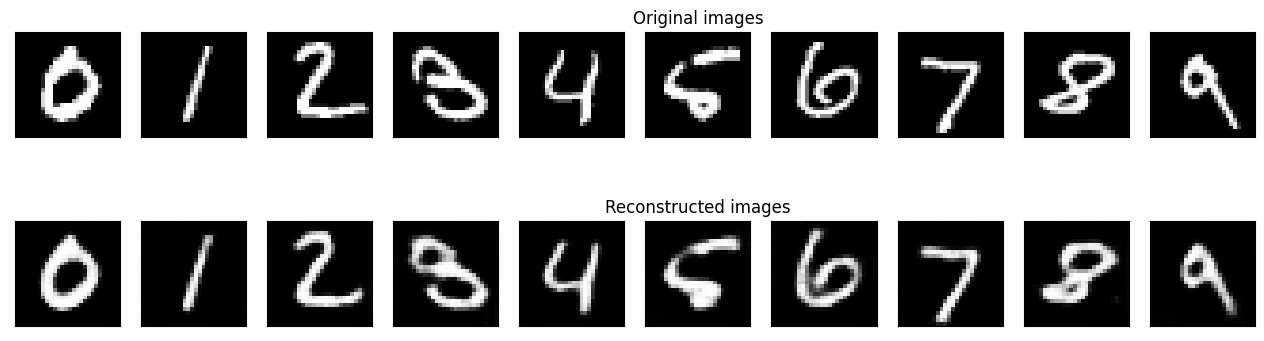

	 partial train loss (single batch): 0.006221
	 partial train loss (single batch): 0.005952
	 partial train loss (single batch): 0.005849
	 partial train loss (single batch): 0.006468
	 partial train loss (single batch): 0.006170
	 partial train loss (single batch): 0.005999
	 partial train loss (single batch): 0.005968
	 partial train loss (single batch): 0.006450
	 partial train loss (single batch): 0.005947
	 partial train loss (single batch): 0.006715
	 partial train loss (single batch): 0.005938
	 partial train loss (single batch): 0.006015
	 partial train loss (single batch): 0.005991
	 partial train loss (single batch): 0.006287
	 partial train loss (single batch): 0.005950
	 partial train loss (single batch): 0.006062
	 partial train loss (single batch): 0.006220
	 partial train loss (single batch): 0.006209
	 partial train loss (single batch): 0.006483
	 partial train loss (single batch): 0.005809
	 partial train loss (single batch): 0.005977
	 partial train loss (single batch

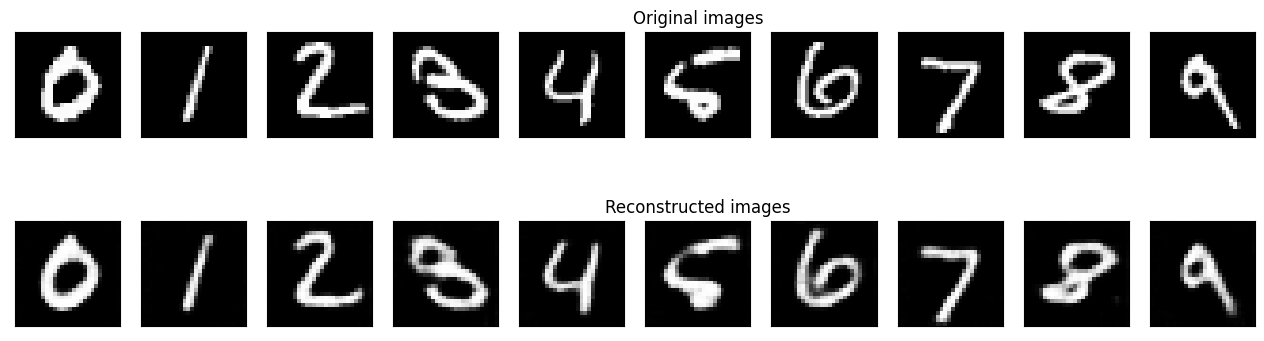

	 partial train loss (single batch): 0.006197
	 partial train loss (single batch): 0.005910
	 partial train loss (single batch): 0.005816
	 partial train loss (single batch): 0.006424
	 partial train loss (single batch): 0.006122
	 partial train loss (single batch): 0.005964
	 partial train loss (single batch): 0.005914
	 partial train loss (single batch): 0.006410
	 partial train loss (single batch): 0.005898
	 partial train loss (single batch): 0.006657
	 partial train loss (single batch): 0.005901
	 partial train loss (single batch): 0.005971
	 partial train loss (single batch): 0.005936
	 partial train loss (single batch): 0.006260
	 partial train loss (single batch): 0.005876
	 partial train loss (single batch): 0.006033
	 partial train loss (single batch): 0.006163
	 partial train loss (single batch): 0.006162
	 partial train loss (single batch): 0.006450
	 partial train loss (single batch): 0.005751
	 partial train loss (single batch): 0.005927
	 partial train loss (single batch

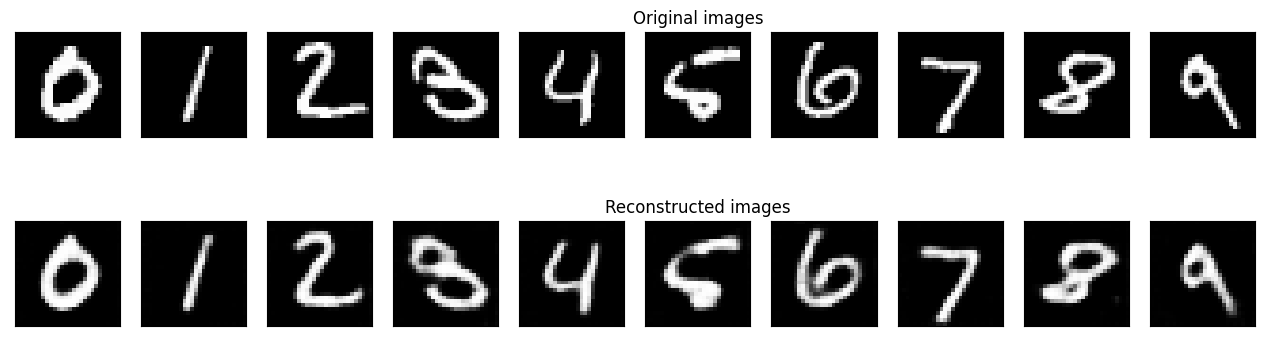

	 partial train loss (single batch): 0.006138
	 partial train loss (single batch): 0.005866
	 partial train loss (single batch): 0.005779
	 partial train loss (single batch): 0.006354
	 partial train loss (single batch): 0.006118
	 partial train loss (single batch): 0.005905
	 partial train loss (single batch): 0.005858
	 partial train loss (single batch): 0.006389
	 partial train loss (single batch): 0.005866
	 partial train loss (single batch): 0.006579
	 partial train loss (single batch): 0.005864
	 partial train loss (single batch): 0.005878
	 partial train loss (single batch): 0.005905
	 partial train loss (single batch): 0.006215
	 partial train loss (single batch): 0.005839
	 partial train loss (single batch): 0.006016
	 partial train loss (single batch): 0.006089
	 partial train loss (single batch): 0.006155
	 partial train loss (single batch): 0.006409
	 partial train loss (single batch): 0.005715
	 partial train loss (single batch): 0.005925
	 partial train loss (single batch

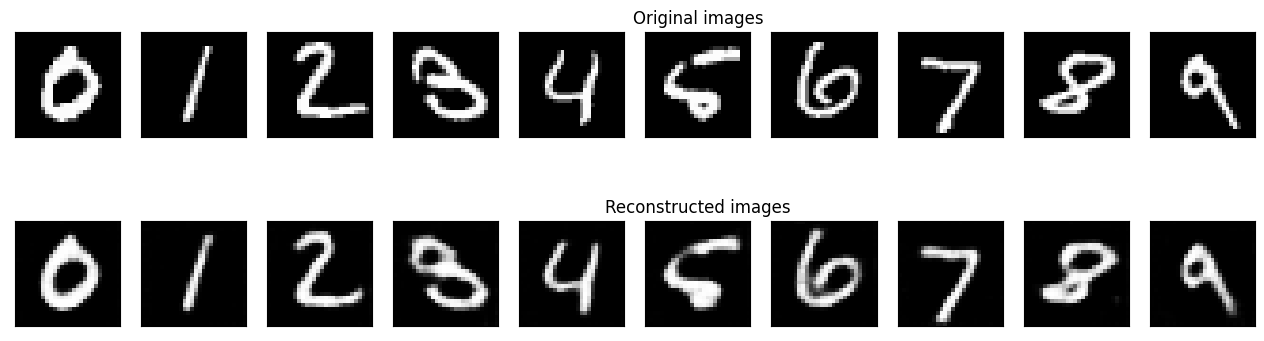

	 partial train loss (single batch): 0.006105
	 partial train loss (single batch): 0.005830
	 partial train loss (single batch): 0.005741
	 partial train loss (single batch): 0.006302
	 partial train loss (single batch): 0.006077
	 partial train loss (single batch): 0.005858
	 partial train loss (single batch): 0.005804
	 partial train loss (single batch): 0.006359
	 partial train loss (single batch): 0.005832
	 partial train loss (single batch): 0.006526
	 partial train loss (single batch): 0.005833
	 partial train loss (single batch): 0.005822
	 partial train loss (single batch): 0.005854
	 partial train loss (single batch): 0.006189
	 partial train loss (single batch): 0.005781
	 partial train loss (single batch): 0.006000
	 partial train loss (single batch): 0.006041
	 partial train loss (single batch): 0.006135
	 partial train loss (single batch): 0.006372
	 partial train loss (single batch): 0.005686
	 partial train loss (single batch): 0.005912
	 partial train loss (single batch

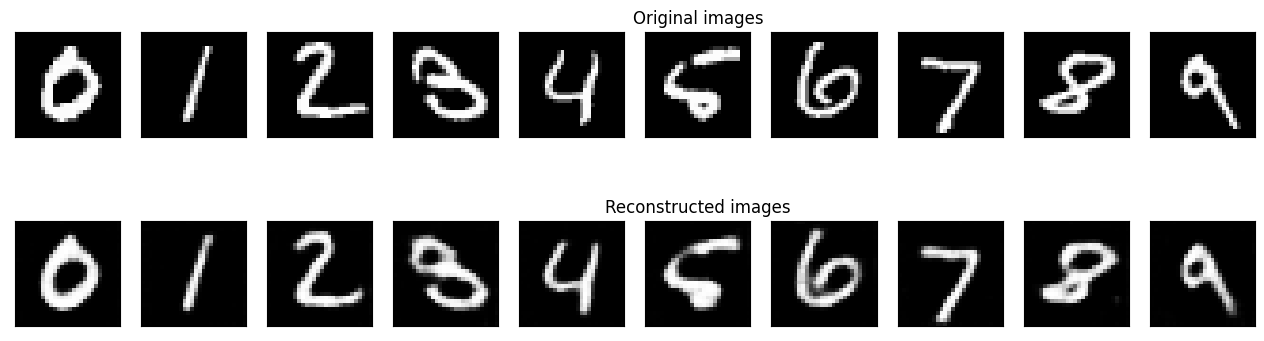

	 partial train loss (single batch): 0.006106
	 partial train loss (single batch): 0.005797
	 partial train loss (single batch): 0.005710
	 partial train loss (single batch): 0.006267
	 partial train loss (single batch): 0.006042
	 partial train loss (single batch): 0.005836
	 partial train loss (single batch): 0.005764
	 partial train loss (single batch): 0.006333
	 partial train loss (single batch): 0.005836
	 partial train loss (single batch): 0.006483
	 partial train loss (single batch): 0.005841
	 partial train loss (single batch): 0.005790
	 partial train loss (single batch): 0.005841
	 partial train loss (single batch): 0.006183
	 partial train loss (single batch): 0.005742
	 partial train loss (single batch): 0.005999
	 partial train loss (single batch): 0.006002
	 partial train loss (single batch): 0.006128
	 partial train loss (single batch): 0.006332
	 partial train loss (single batch): 0.005680
	 partial train loss (single batch): 0.005915
	 partial train loss (single batch

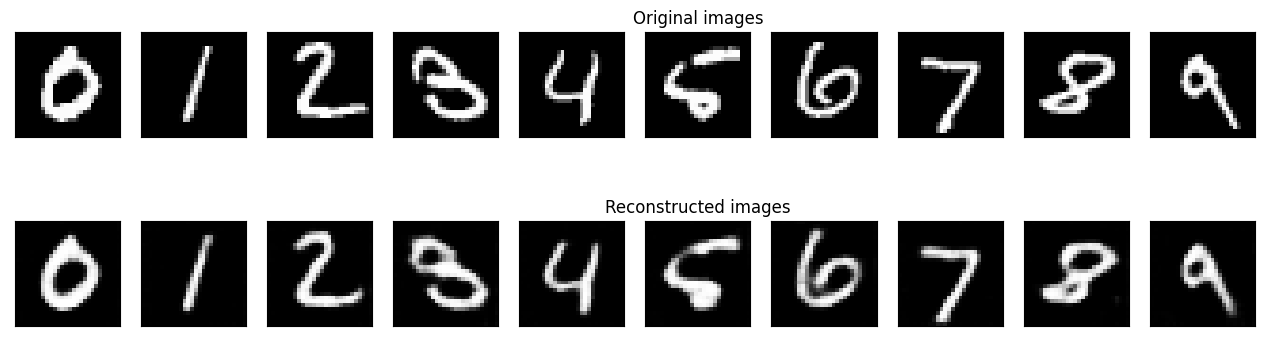

	 partial train loss (single batch): 0.006148
	 partial train loss (single batch): 0.005747
	 partial train loss (single batch): 0.005782
	 partial train loss (single batch): 0.006283
	 partial train loss (single batch): 0.005967
	 partial train loss (single batch): 0.005869
	 partial train loss (single batch): 0.005753
	 partial train loss (single batch): 0.006356
	 partial train loss (single batch): 0.005866
	 partial train loss (single batch): 0.006473
	 partial train loss (single batch): 0.005936
	 partial train loss (single batch): 0.005801
	 partial train loss (single batch): 0.005887
	 partial train loss (single batch): 0.006176
	 partial train loss (single batch): 0.005801
	 partial train loss (single batch): 0.005966
	 partial train loss (single batch): 0.006097
	 partial train loss (single batch): 0.006124
	 partial train loss (single batch): 0.006349
	 partial train loss (single batch): 0.005809
	 partial train loss (single batch): 0.005834
	 partial train loss (single batch

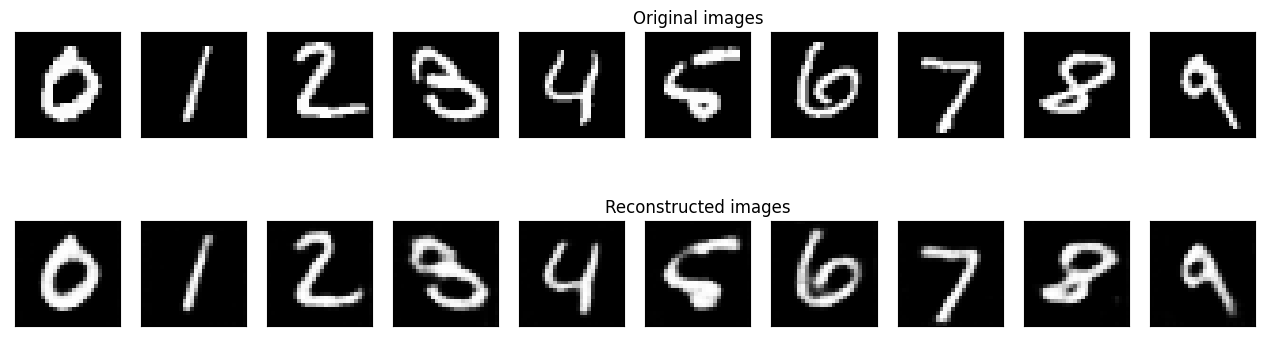

In [7]:
num_epochs = 40
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optim)
   val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn)
   print('\n EPOCH {}/{}; \t train loss {}; \t val loss {};'.format(epoch + 1, num_epochs, train_loss, val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_test(encoder, decoder)

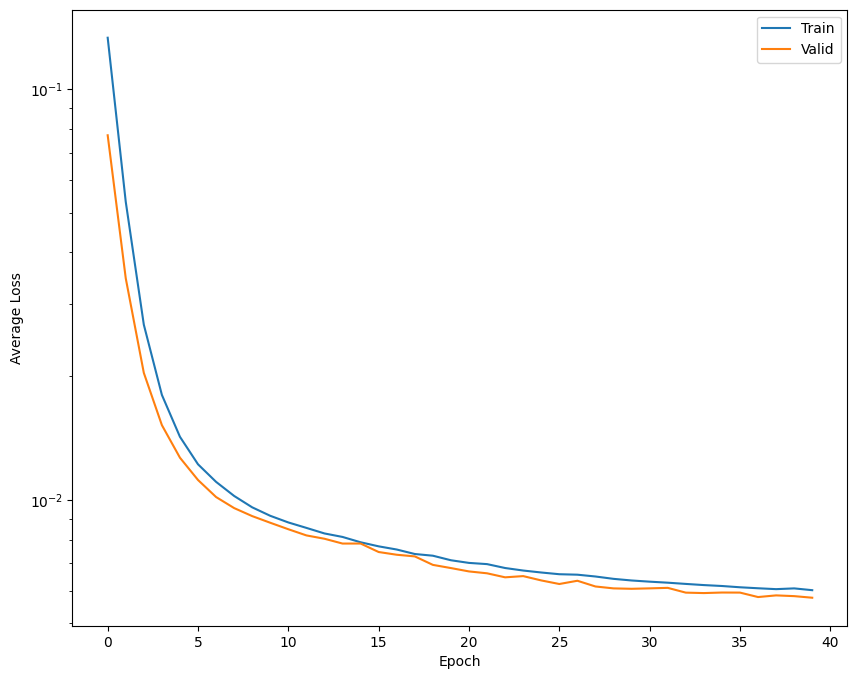

In [8]:
plt.figure(figsize=(10, 8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
plt.title('loss')
plt.show()